In [58]:
import numpy as np
import pandas as pd
train = pd.read_csv('./data/train.csv')
test  = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/submission.csv')

In [59]:
#케라스가 내 모델에 맞추기 위해 사용할 수 있는 one-hot 벡터 배열을 one-hot 벡터 배열로 바꾸기
from keras.utils.np_utils import to_categorical
#입력이미지의 shape 이 (batch_size, width, height, n_channels)로 넣어줘야함
X_train = (train[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 28, 28, 1)

#레이블 준비하기
y_train = to_categorical(train['digit'].values)
print(X_train[0].shape)
print(len(y_train))

(28, 28, 1)
2048


# KERAS 신경망 구현 순서
1. **Sequential** 모형 클래스 객체 생성 <br>
<br>
2. **add** 메서드로 레이어 추가<br>
    - 입력단부터 순차적으로 추가
    - 레이어는 출력 뉴런갯수를 첫번째 인수로 받는다
    - 최초 레이어는 **input_dim** 인수로 입력크기를 설정
    - **activation** 인수로 활성화 함수 설정 <br>
    <br>
3. **compile** 메서드로 모형 완성
    - **loss** 인수로 비용함수 설정
    - **optimizer** 인수로 최적화 알고리즘 설정
    - **metrics** 인수로 트레이닝 단계에서 기록할 성능 기준 설정<br>
    <br>
4. **fit** 메서드로 트레이닝
    - **nb_epoch** 로 에포크 횟수 설정
    - **batch_size** 로 배치 크기 설정
    - **verbose**는 학습 중 출력되는 문구 설정. <verbose = 2> 는 진행막대가 나오지않도록 설정

In [60]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# 아마 성능 향상의 가장 큰 요인, 데이터 증강
# CREATE MORE IMAGES VIA DATA AUGMENTATION
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [61]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout, MaxPool2D,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add
)

model = Sequential() #클래스 객체 생성
model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))  #26 * 26 * 32
model.add(Conv2D(32, kernel_size = 3, activation='relu')) # 24 * 24 * 32
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu')) #12 * 12 * 32
model.add(Dropout(0.4)) 

model.add(Conv2D(64, kernel_size = 3, activation='relu')) # 10 * 10 * 64
model.add(Conv2D(64, kernel_size = 3, activation='relu')) # 8 * 8 * 64
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu')) # 4 * 4 * 64
model.add(Dropout(0.4)) 

model.add(Conv2D(128, kernel_size = 4, activation='relu')) # 1 * 1 * 128
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

In [62]:
# COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [63]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 12, 12, 32)        25632     
_________________________________________________________________
dropout_19 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 4, 4, 64)         

In [64]:
# 좀 더 빨리 하기 위함
from tensorflow.keras.callbacks import LearningRateScheduler
# DECREASE LEARNING RATE EACH EPOCH
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

In [65]:
from sklearn.model_selection import train_test_split
epochs = 45
# Train-Test를 9:1로 분리
X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X_train, y_train, test_size = 0.1)

#fit 메서드로 트레이닝 시작
hist = model.fit_generator(
    datagen.flow(X_train2, y_train2, batch_size=32),
    epochs=epochs, 
    steps_per_epoch=X_train2.shape[0]//32,
    validation_data=(X_val2, y_val2), 
    callbacks=[annealer], 
    verbose=0
)
print(
    f"CNN: Epochs={epochs:d}, " +
    f"Train accuracy={max(hist.history['acc']):.5f}, " +
    f"Validation accuracy={max(hist.history['val_acc']):.5f}"
)

CNN: Epochs=45, Train accuracy=0.73971, Validation accuracy=0.85366


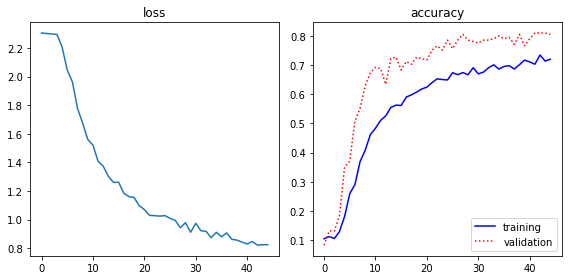

In [50]:
#성능 visualize
import matplotlib.pyplot as plt 
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'])
plt.title("loss")
plt.subplot(1, 2, 2)
plt.title("accuracy")
plt.plot(hist.history['acc'], 'b-', label="training")
plt.plot(hist.history['val_acc'], 'r:', label="validation")
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
# Parameter 및 모델 구조 저장
model.save_weights(f'params.h5')
    
model_json = model.to_json()
with open(f"model.json", "w") as json_file : 
    json_file.write(model_json)

In [26]:
# 예측 진행
X_test = (test[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 28, 28, 1)
results = model.predict(X_test)

In [27]:
submission.digit = results
submission.to_csv('1234.csv', index=False)